<a href="https://colab.research.google.com/github/KhanutBJ/Migraine_CNN/blob/main/Migraine_BCI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Builders project: BCI for Migraine**

By Khanut Boonjong

A CNN model developed as a classifier for SSVEP-based Brain-Computer Interface (BCI) for Migraine which may potentially be implemented in neurofeedback training or diagnostic protocol.

Install and import libraries

In [1]:
! pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 14.8 MB/s 


In [2]:
import numpy as np
import pandas as pd
import mne as mne
import matplotlib.pyplot as plt
import torch
from scipy.stats import ttest_rel
from torch.utils.data import DataLoader
from mne.time_frequency import stft,istft
import os

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading raw EEG (for visualization purpose)

Extracting EDF parameters from /content/gdrive/MyDrive/AIBuilders/Migraine/M1_SSVEP.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388607  =      0.000 ...   758.998 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<ipython-input-4-20f3e750e270>:5: RuntimeWarning: DigMontage is only a subset of info. There are 13 channel positions not present in the DigMontage. The required channels are:

['LO1', 'LO2', 'IO1', 'SO1', 'IO2', 'ECG', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage("standard_1005", match_case=False, on_missing='warn')


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 38 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 38.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


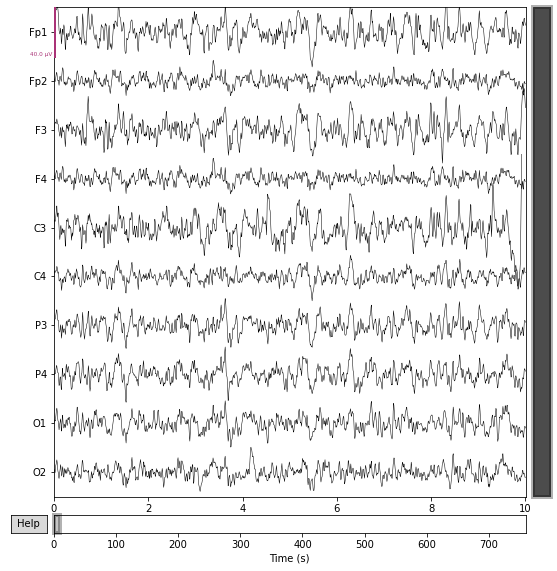

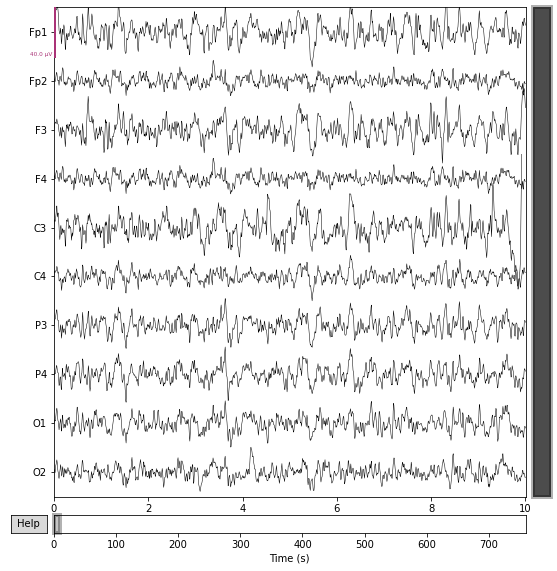

In [4]:
# raw migraine EEG

#read EEG
raw = mne.io.read_raw_bdf('/content/gdrive/MyDrive/AIBuilders/Migraine/M1_SSVEP.bdf', preload=True)
raw.set_montage("standard_1005", match_case=False, on_missing='warn')
raw.set_eeg_reference(ref_channels=['Fpz'])
raw.pick_channels(['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2'], ordered=True)

#filter
raw.notch_filter(60) 
raw_filt = raw.filter(1,38, method='iir', iir_params=dict(ftype='butter', order=3))

raw_filt.plot()

Extracting EDF parameters from /content/gdrive/MyDrive/AIBuilders/Control/C1_SSVEP.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 382463  =      0.000 ...   746.998 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<ipython-input-5-54ffa68c9d31>:5: RuntimeWarning: DigMontage is only a subset of info. There are 13 channel positions not present in the DigMontage. The required channels are:

['LO1', 'LO2', 'IO1', 'SO1', 'IO2', 'ECG', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_control.set_montage("standard_1005", match_case=False,on_missing='warn')


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 38 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 38.00 Hz: -6.02, -6.02 dB

Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


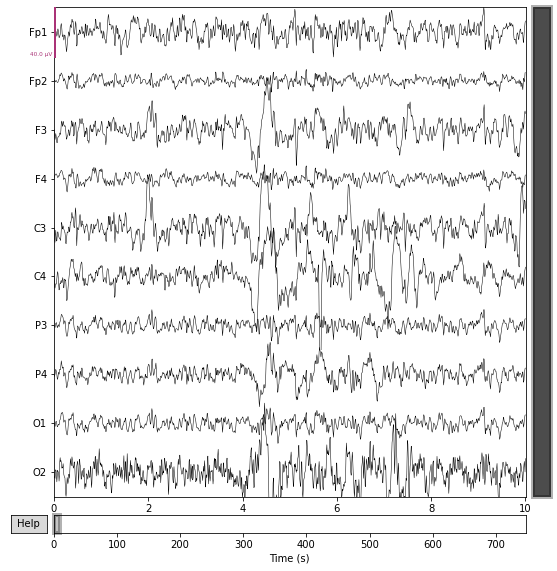

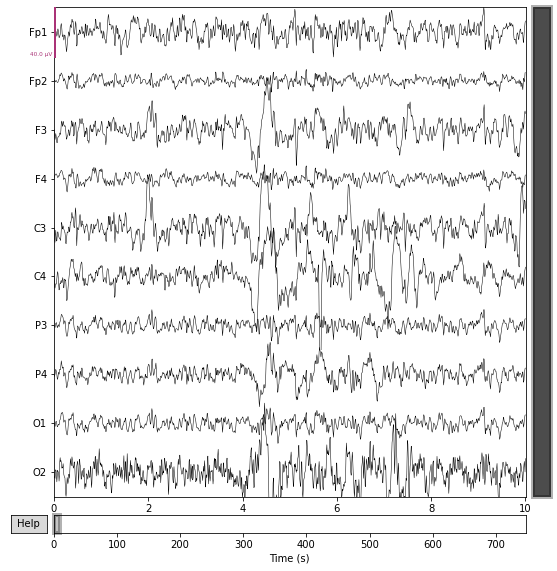

In [5]:
# raw control EEG

#read EEG
raw_control = mne.io.read_raw_bdf('/content/gdrive/MyDrive/AIBuilders/Control/C1_SSVEP.bdf', preload=True)
raw_control.set_montage("standard_1005", match_case=False,on_missing='warn')
raw_control.set_eeg_reference(ref_channels=['Fpz'])
raw_control.pick_channels(['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2'], ordered=True)   

#filter
raw_control.notch_filter(60)
raw_filt_control = raw_control.filter(1,38, method='iir', iir_params=dict(ftype='butter', order=3))

raw_filt_control.plot()

Dataset preparation and preprocessing

According to the research [1], data collection was performed with ground (reference) at FpZ channel. Sampling rate was set to 512 Hz [2] and specific frequencies within range 1-38 Hz was chosen to determine peak amplitude by using third-order filter. 60 Hz notch filter was used for noise elimination



[1] 
https://behavioralandbrainfunctions.biomedcentral.com/track/pdf/10.1186/1744-9081-6-9.pdf

[2] 
https://doi.org/10.1093/braincomms/fcab061

In [6]:
""" 
data can be obtained from:
    MIGRAINE: https://drive.google.com/drive/folders/11s6nZlc7vT3LAmCsi9fv24Vgg-NWR9Hv?usp=sharing
    CONTROL: https://drive.google.com/drive/folders/11v-6jAimU0NAu_6FUbXC3j4yJtd4440t?usp=sharing

Note: 
dataset collected from 
"Ultra high-density EEG recording of interictal migraine and controls: sensory and rest"
link: https://kilthub.cmu.edu/articles/dataset/Ultra_high-density_EEG_recording_of_interictal_migraine_and_controls_sensory_and_rest/12636731

"""

migraine_path = '/content/gdrive/MyDrive/AIBuilders/Migraine' # 18 migraine subjects
control_path = '/content/gdrive/MyDrive/AIBuilders/Control' # 18 control subject

# change path as you wish

def preprocess(path):

    raw = mne.io.read_raw_bdf(path, preload=True, verbose=0)
    raw.set_montage("standard_1005", match_case=False,on_missing='ignore',verbose=0 )
    raw.set_eeg_reference(ref_channels=['Fpz'], verbose=0)
    raw.pick_channels(['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2'], ordered=True)   
    raw_filt = raw.notch_filter(60, verbose=0)
    raw_filt = raw.filter(1,38, method='iir', iir_params=dict(ftype='butter', order=3), verbose=0)
    return raw_filt

#convert raw to numerical notation

def Getdata(raw,stype):

    data_x = []
    data_y = []

    sampling_rate = 512

    #epoching with window size of 30 s
    window_size = 30

    for i in range(0,len(raw.get_data()[0]),sampling_rate*window_size):
        if(i+(sampling_rate*window_size) < len(raw.get_data()[0])):
            data_x.append(raw.get_data()[:,i:i+(sampling_rate*window_size)])
            if stype == 'm': data_y.append(1)
            elif stype == 'c': data_y.append(0)

    data_x = np.expand_dims(np.swapaxes(data_x,1,2), axis=1)   # ensure x and y have the same shape

    if stype == 'm': 
      migraine_x.extend(data_x)
      migraine_y.extend(data_y)
    elif stype == 'c': 
      control_x.extend(data_x)
      control_y.extend(data_y)

In [7]:
#preprocess + data extraction

migraine_x = []
migraine_y = []

for file in os.listdir(migraine_path):

  path = os.path.join(migraine_path,file)
  raw_filt = preprocess(path)
  Getdata(raw_filt,'m')

In [8]:
control_x = []
control_y = []

for file in os.listdir(control_path):

  path = os.path.join(control_path,file)
  raw_filt = preprocess(path)
  Getdata(raw_filt,'c')

In [9]:
# combine migraine and control data

feat = np.asarray(migraine_x + control_x)
label = np.asarray(migraine_y + control_y)

In [10]:
#save files

np.save('/content/gdrive/MyDrive/AIBuilders/feat', feat)
np.save('/content/gdrive/MyDrive/AIBuilders/label', label)

In [11]:
#read files

feat = np.load('/content/gdrive/MyDrive/AIBuilders/feat.npy',  allow_pickle=True)
label = np.load('/content/gdrive/MyDrive/AIBuilders/label.npy',  allow_pickle=True)

In [12]:
#zip feature and label to dataset

ds = list(zip(feat,label))
len(ds)

882

Modeling

We will build a CNN model based on the state-of-the-art EEGNet which is recommended as a feature extractor and a classifier for BCI task.

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [27]:
# define model 

class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 10), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        self.fc1 = nn.Linear(2560*3, 1)
        
    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1,2560*3)
        x = torch.sigmoid(self.fc1(x))
        return x

model = EEGNet().cuda(0)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [28]:
#define metrics

def evaluate(model, X, Y, params):
    results = []
    predicted = []
 
    inputs = Variable(X)
    pred = model(inputs.cuda(0))
    
    predicted.append(pred.cpu().detach().numpy())
    predicted = pred.cpu().detach().numpy()
    
    for param in params:
      if param == "acc":
        results.append(accuracy_score(Y, np.round(predicted.reshape(-1,)[:len(Y)])))
      if param == "recall":
        results.append(recall_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
      if param == "precision":
        results.append(precision_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
      if param == "f1":
        results.append(f1_score(Y, np.round(predicted.reshape(-1,)[:len(Y)]),zero_division=0))
  
    return results

In [29]:
# split train/test
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

# split train/val
val_size = int(0.2 * train_size)
train_size = train_size - val_size
train_dataset,val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

#dataloader
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dl = DataLoader(val_dataset,batch_size=32,shuffle=False)
test_dl = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [30]:
#save default model
torch.save(model,"/content/model_default")

Epoch  0
['acc', 'recall', 'precision', 'f1']
Training Loss  1.2512004011207156
Validation Loss  0.9633782029151916
Train -  [0.55, 0.0, 0.0, 0.0]
Validation -  [0.38461538461538464, 0.1111111111111111, 1.0, 0.19999999999999998]
highest validation accuracy: 0.38461538461538464
Epoch  1
['acc', 'recall', 'precision', 'f1']
Training Loss  0.9395811094178094
Validation Loss  0.6511118650436402
Train -  [0.85, 0.875, 0.7777777777777778, 0.823529411764706]
Validation -  [0.6923076923076923, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778]
highest validation accuracy: 0.7692307692307693
Epoch  2
['acc', 'recall', 'precision', 'f1']
Training Loss  0.6773903667926788
Validation Loss  0.6930608749389648
Train -  [0.45, 0.5555555555555556, 0.4166666666666667, 0.4761904761904762]
Validation -  [0.46153846153846156, 0.2222222222222222, 1.0, 0.3636363636363636]
Epoch  3
['acc', 'recall', 'precision', 'f1']
Training Loss  0.5494240555498335
Validation Loss  0.6659309506416321
Train -  [0.

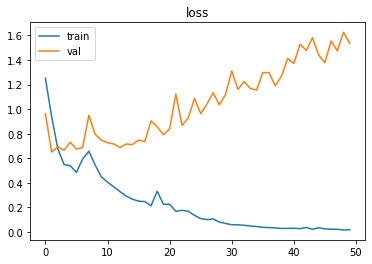

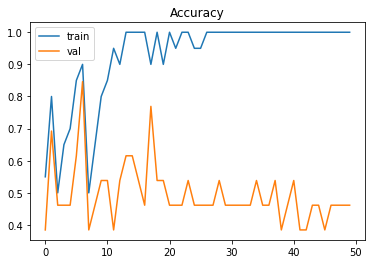

train size: 564 | val size: 141


In [31]:
#train model

from numpy.lib.function_base import average

iteration = 50

avg_train_loss = []
avg_val_loss = []

accuracy_train = []
accuracy_val = []

highest_valacc = 0

model = torch.load("/content/model_default")
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(iteration):  
    print ("============================================================================================================\nEpoch ",epoch)  

    # training set
    running_loss_train = []
    
    for i,(x,y) in enumerate(train_dl):
        train_data = x
        train_label = y.reshape(-1,1)

        inputs, labels = Variable(train_data), Variable(train_label)
        optimizer.zero_grad()
        outputs = model(inputs.to(device=torch.device("cuda:0"), dtype=torch.float))
        loss = criterion(outputs, labels.to(device=torch.device("cuda:0"), dtype=torch.float))
        loss.backward()
        optimizer.step()
        running_loss_train.append(loss.item())

    # validation set
    running_loss_val = []

    for i,(x,y) in enumerate(val_dl):

        val_data = x
        val_label = y.reshape(-1,1)

        inputs, labels = Variable(val_data), Variable(val_label)
        outputs = model(inputs.to(device=torch.device("cuda:0"), dtype=torch.float))
        loss = criterion(outputs, labels.to(device=torch.device("cuda:0"), dtype=torch.float))

        running_loss_val.append(loss.item())

    # metrics input/output
    params = ["acc","recall","precision","f1"]
    print (params)

    print ("Training Loss ", average(running_loss_train))
    avg_train_loss.append(average(running_loss_train))

    print ("Validation Loss ", average(running_loss_val))
    avg_val_loss.append(average(running_loss_val))

    print ("Train - ", evaluate(model, train_data.to(device=torch.device("cuda:0"), dtype=torch.float), train_label, params))
    print ("Validation - ", evaluate(model, val_data.to(device=torch.device("cuda:0"), dtype=torch.float), val_label, params))

    accuracy_train.append(evaluate(model, train_data.to(device=torch.device("cuda:0"), dtype=torch.float), train_label, params)[0])
    accuracy_val.append(evaluate(model, val_data.to(device=torch.device("cuda:0"), dtype=torch.float), val_label, params)[0])

    # save model at highest validation accuracy
    if highest_valacc < average(evaluate(model, val_data.to(device=torch.device("cuda:0"), dtype=torch.float), val_label, params)[0]):
      highest_valacc = average(evaluate(model, val_data.to(device=torch.device("cuda:0"), dtype=torch.float), val_label, params)[0])
      print("highest validation accuracy:",highest_valacc)
      torch.save(model,"/content/model_default")

# loss plot   
plt.title("loss")
plt.plot(avg_train_loss, label = 'train')
plt.plot(avg_val_loss, label = 'val')
plt.legend()
plt.show() 

# accuracy plot
plt.title("Accuracy")
plt.plot(accuracy_train, label = 'train')
plt.plot(accuracy_val, label = 'val')
plt.legend()
plt.show() 

print("train size:",train_size, "| val size:",val_size)

In [32]:
# test set

model = torch.load("/content/model_default")

running_loss_test = []
avg_metrics = []

for i,(x,y) in enumerate(test_dl):

    test_data = x
    test_label = y.reshape(-1,1)

    inputs, labels = Variable(test_data), Variable(test_label)
    outputs = model(inputs.to(device=torch.device("cuda:0"), dtype=torch.float))
    loss = criterion(outputs, labels.to(device=torch.device("cuda:0"), dtype=torch.float))

    running_loss_test.append(loss.item())
    avg_metrics.append(evaluate(model, val_data.to(device=torch.device("cuda:0"), dtype=torch.float), val_label, params)[0])

print("test loss:",average(running_loss_test))
print("test accuracy:",average(avg_metrics))

test loss: 0.9143645266691843
test accuracy: 0.7179487179487181


In [39]:
labels

tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0]])

In [40]:
outputs

tensor([[0.8026],
        [0.6262],
        [0.7732],
        [0.5136],
        [0.6721],
        [0.3652],
        [0.5968],
        [0.9682],
        [0.7707],
        [0.4429],
        [0.3943],
        [0.6652],
        [0.7566],
        [0.9707],
        [0.7087],
        [0.5586],
        [0.6138]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Comparing performance with other models

In [33]:
# prepare dataloader for SVM and XGB

train_dl = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True)
val_dl = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=False)
test_dl = DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

In [34]:
# Support Vector Machine(SVM)

from sklearn import svm

# initialize model
clf = svm.SVC()

for i,(x,y) in enumerate(train_dl):

    x = np.reshape(x,(x.shape[0],x.shape[2]*x.shape[3]))
    clf = clf.fit(x,y)
    accuracy = accuracy_score(clf.predict(x), np.asarray(y))
    print("training accuracy:", accuracy)

for i,(x,y) in enumerate(test_dl):

    x = np.reshape(x,(x.shape[0],x.shape[2]*x.shape[3]))
    accuracy = accuracy_score(clf.predict(x), np.asarray(y))
    print("test accuracy:", accuracy)

training accuracy: 0.5088652482269503
test accuracy: 0.5028248587570622


In [35]:
# XGBoost

import xgboost as xgb

# initialize model
clf = xgb.XGBClassifier()

for i,(x,y) in enumerate(train_dl):

    x = np.reshape(x,(x.shape[0],x.shape[2]*x.shape[3]))
    clf = clf.fit(x,y)
    accuracy = accuracy_score(clf.predict(x), np.asarray(y))
    print("training accuracy:", accuracy)

for i,(x,y) in enumerate(test_dl):

    x = np.reshape(x,(x.shape[0],x.shape[2]*x.shape[3]))
    accuracy = accuracy_score(clf.predict(x), np.asarray(y))
    print("test accuracy:", accuracy)

training accuracy: 1.0
test accuracy: 0.632768361581921


save model as pickle

In [41]:
import pickle

final_model = torch.load("/content/model_default")
pickle.dump(final_model, open('model.pkl', 'wb'))